In [1]:
import io
import numpy as np
import torchvision

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
import torch.nn as nn
import torch.nn.init as init
import onnx
import onnxruntime
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

Hyperparameters

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Load the MNIST dataset

In [14]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

1.0%

100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




19.9%

100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100.0%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



torch.Size([1000, 1, 28, 28])


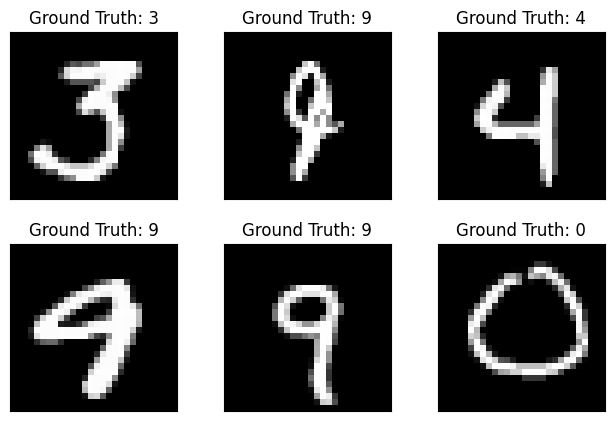

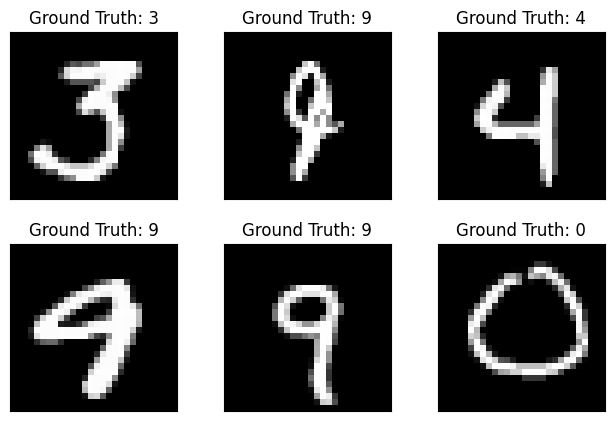

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
class NetSimple(nn.Module):
    def __init__(self):
        super(NetSimple,self).__init__()
        self.conv1 = nn.Conv2d(1 , 10 , kernel_size= 5)
        self.conv2 = nn.Conv2d(10 , 20 , kernel_size= 5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x ):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
        
networkSimple = NetSimple()
optimizer = optim.SGD(networkSimple.parameters(), lr=learning_rate,
                      momentum=momentum)

In [6]:

def train(epoch):
    networkSimple.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = networkSimple(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(networkSimple.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

In [7]:
def test():
    networkSimple.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = networkSimple(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/var/folders/qk/st4v94_949n0_8cn5pjn22z00000gn/T/ipykernel_72925/1412990414.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [12160/6

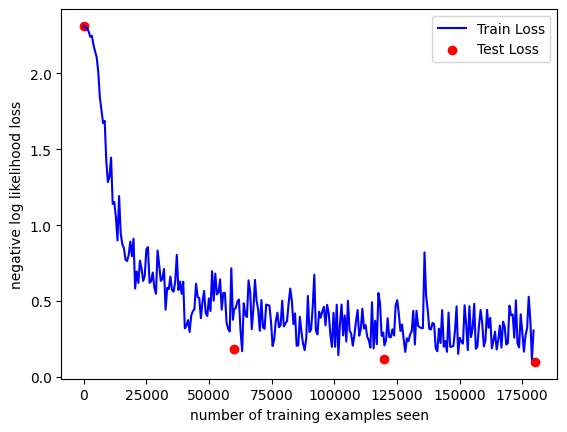

In [9]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

/var/folders/qk/st4v94_949n0_8cn5pjn22z00000gn/T/ipykernel_72925/1412990414.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


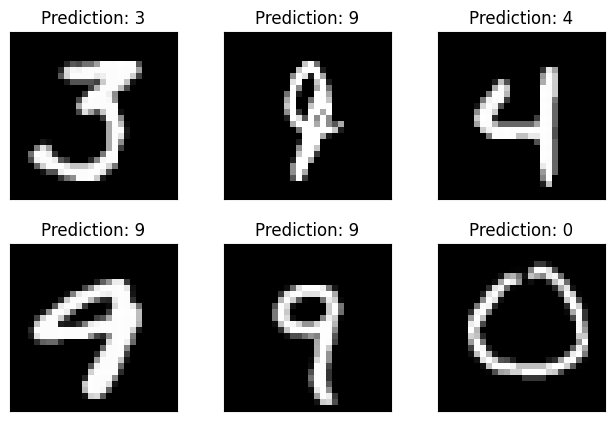

In [10]:
with torch.no_grad():
    output = networkSimple(example_data)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [11]:
from torch.autograd import Variable

torch_out = torch.onnx.export( networkSimple, example_data, "MNIST.onnx", export_params=True, verbose=True)

/var/folders/qk/st4v94_949n0_8cn5pjn22z00000gn/T/ipykernel_72925/1412990414.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Exported graph: graph(%input.1 : Float(1000, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv1.weight : Float(10, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(10, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(20, 10, 5, 5, strides=[250, 25, 5, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(20, strides=[1], requires_grad=1, device=cpu),
      %fc1.weight : Float(50, 320, strides=[320, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(50, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(10, 50, strides=[50, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/conv1/Conv_output_0 : Float(1000, 10, 24, 24, strides=[5760, 576, 24, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[1, 1], onnx_name="/conv1/Conv"](%input.1, %con

In [12]:
onnx_model = onnx.load("MNIST.onnx")
onnx.checker.check_model(onnx_model)


ort_session = onnxruntime.InferenceSession("MNIST.onnx")


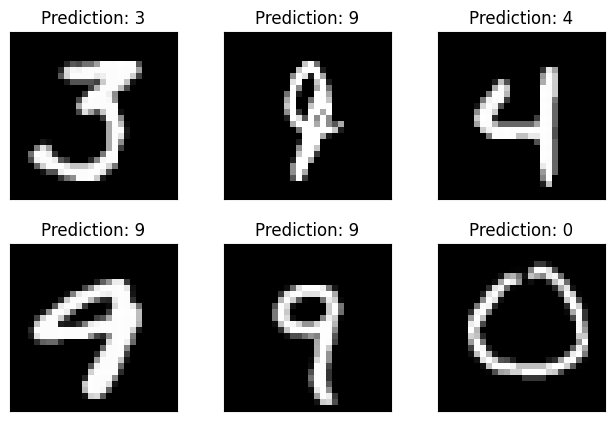

In [13]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()




ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(example_data)}
output = ort_session.run(None, ort_inputs)[0]


fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        np.argmax(output[i])))
    plt.xticks([])
    plt.yticks([])
plt.show()
